In [0]:
!pip install git+https://github.com/pymc-devs/pymc3

In [0]:
import pymc3 as pm
from pymc3.ode import DifferentialEquation
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import arviz as az
import theano


In [0]:
def SIR(y, t, p):
    # dSdt = -beta * S * I / N
    # dIdt = beta * S * I / N - gamma * I
    # dRdt = gamma * I

    # gamma = 1 / D ~ 1 / Days infectious
    # beta = probability of transmission
    # R0 = beta/gamma
    # F = beta * I

    beta, gamma = p[0], p[1]
    S, I, R = y[0], y[1], y[2]
    N = S + I + R

    ds = - beta * S * I / N
    di = beta * S * I / N - gamma * I
    dr = gamma * I
    return [ds, di, dr]
  
  
def SEIR(y, t, p):
    # No reinfection
    # Lamda - birth rate
    # mu - death rate
    # dSdt = -beta * S * I / N
    # dIdt = beta * S * I / N - gamma * I
    # dRdt = gamma * I

    # gamma = 1 / D ~ 1 / Days infectious
    # beta = probability of transmission per contact
    # epsilon = rate of progression from E to I
    # r = Num contacts at t
    # R0 = r * beta * 1/(gamma + mu) * epsilon/(epsilon + mu)
    # R0 = (Num contacts at t) * (prob of transmission per contact) * (duration of infection) * (prob of surviving Exposed stage)
    # F = beta * I

    beta, gamma, eps = p[0], p[1], p[2]
    S, E, I, R = y[0], y[1], y[2], y[3]
    N = S + E + I + R

    # simple model
    Lamda = 0.0
    mu = 0.0
    r = 1.0

    ds = - r * beta * S * I / N + (Lamda - mu) * S
    de = r * beta * S * I / N - (eps + mu) * E
    di = eps * E - (gamma + mu) * I
    dr = gamma * I - mu * R
    return [ds, de, di, dr]

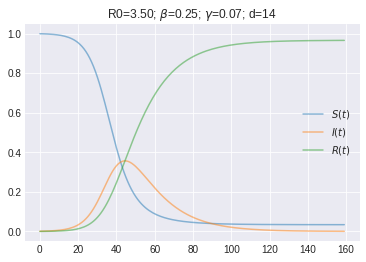

In [14]:
# Parrameters to change
# This needs to be changed to the length of Y_obs
times = np.arange(0, 160, 1)
beta, gamma = 0.25, 1./14
# This should be changed to the real data... [S0/N, I0/N, R0/N]
y_start = [999.0/1000, 1.0/1000, 0.0]


# Create true curves
# y0 = [S/N, I]
y = odeint(SIR, t=times, y0=y_start, args=((beta, gamma),), rtol=1e-8)
# Observational model.  Lognormal likelihood isn't appropriate, but we'll do it anyway
yobs = np.random.lognormal(mean=np.log(y[1::]), sigma=[0.2, 0.3, 0.2])

plt.figure()
# plt.plot(times[1::], yobs, marker='o', linestyle='none')
plt.plot(times, y[:, 0], color='C0', alpha=0.5, label=f'$S(t)$')
plt.plot(times, y[:, 1], color='C1', alpha=0.5, label=f'$I(t)$')
plt.plot(times, y[:, 2], color='C2', alpha=0.5, label=f'$R(t)$')
plt.legend()
plt.title(f'R0={beta/gamma:.2f}; $\\beta$={beta}; $\\gamma$={gamma:.2f}; d={14}')
plt.show()

In [0]:
# times needs to be changed to reflect y_obs
# You can change func to different function but this needs to be reflected in Y-n_states,(beta, gamma)-n_theta
# here and lower in the code
sir_model = DifferentialEquation(
    func=SIR,
    times=np.arange(1, 160, 1),
    n_states=3,
    n_theta=2,
    t0=0,
)


In [16]:
# Here you can change:
# any distribution you want...
# 
# in pm.sample:
#   the number of iterations (500)
#   starting
with pm.Model() as model4:
    sigma = pm.HalfCauchy('sigma', 1, shape=3)

    # R0 is bounded below by 1 because we see an epidemic has occurred
    R0 = pm.Bound(pm.Normal, lower=1)('R0', 2, 3)
    gamma = pm.Lognormal('gamma', pm.math.log(2), 2)
    beta = pm.Deterministic('beta', gamma*R0)

    sir_curves = sir_model(y0=y_start, theta=[beta, gamma])

    Y = pm.Lognormal('Y', mu=pm.math.log(sir_curves), sd=sigma, observed=yobs)

    prior = pm.sample_prior_predictive()
    step = pm.Metropolis()
    # trace = pm.sample(2000, tune=1000, target_accept=0.9, cores=1, step=step)
    # trace = pm.sample(500, tune=500, target_accept=0.9, cores=1, start={'lamda': 1.2, 'beta': 1./0.25})
    trace = pm.sample(500, tune=500, cores=2, start={'gamma': 0.016, 'beta': 0.25}, step=step)
    posterior_predictive = pm.sample_posterior_predictive(trace)

    data = az.from_pymc3(trace=trace, prior=prior, posterior_predictive=posterior_predictive)


Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [gamma]
>Metropolis: [R0]
>Metropolis: [sigma]


Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 484 seconds.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


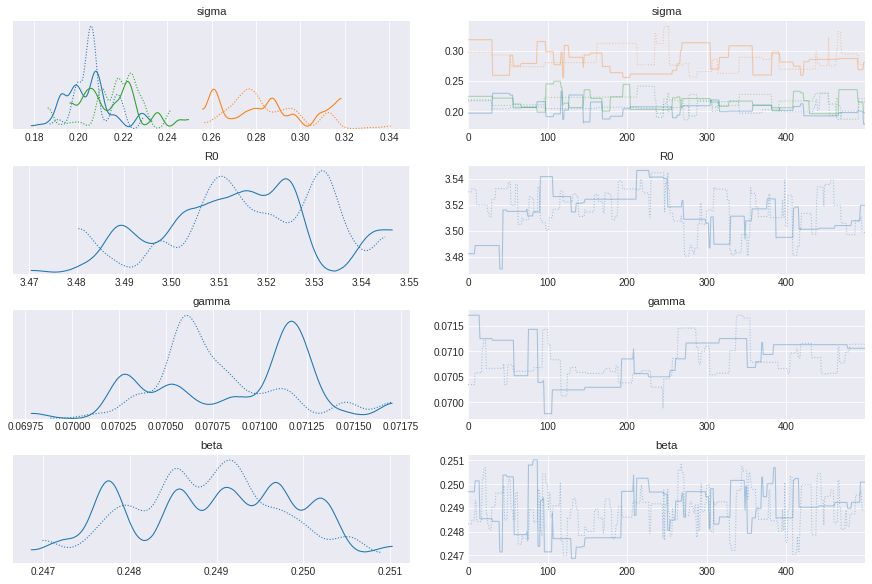

In [17]:
# plots
pm.traceplot(trace);
# pm.energyplot(trace);
# az.plot_posterior(data, round_to=2, credible_interval=0.95);
# pm.summary(trace, var_names=['R0']).round(0)
# pm.forestplot(trace, var_names=['R0'])

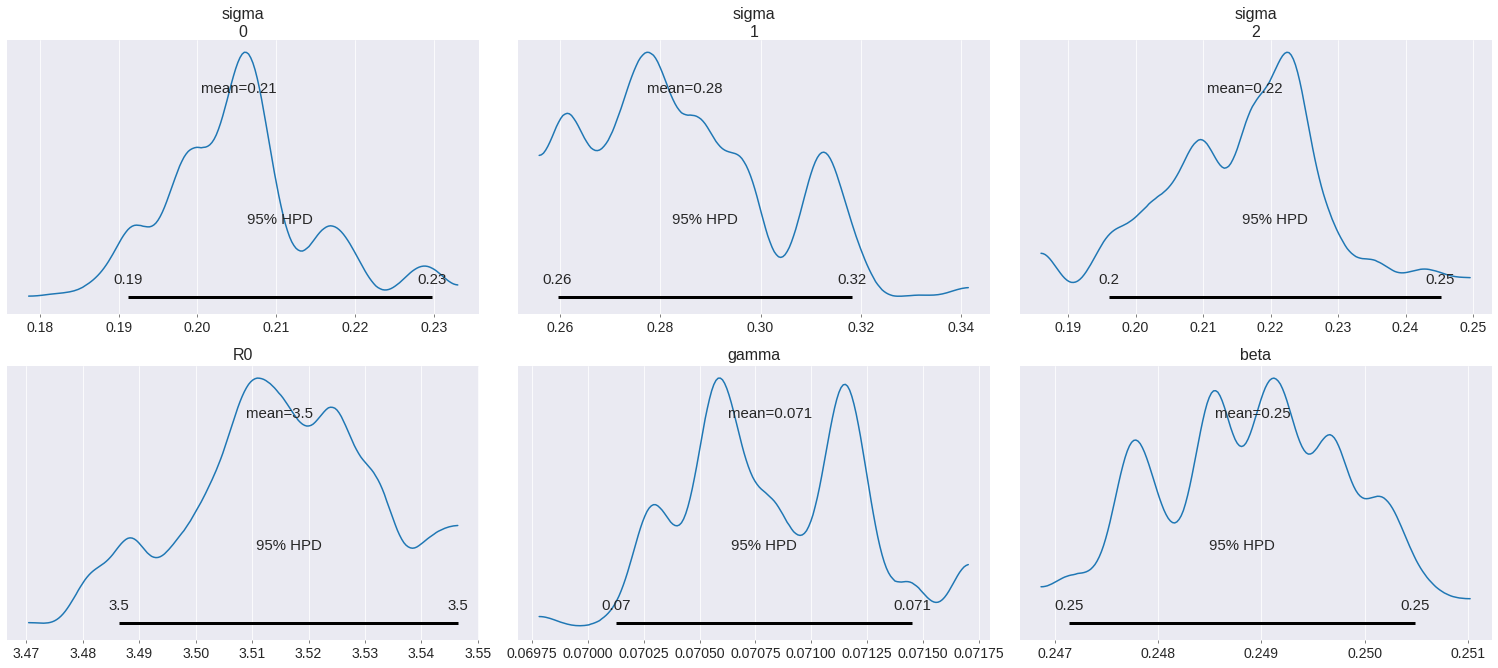

In [18]:
# pm.energyplot(trace);
az.plot_posterior(data, round_to=2, credible_interval=0.95);
# pm.summary(trace, var_names=['R0']).round(0)
# pm.forestplot(trace, var_names=['R0'])

In [21]:
pm.summary(trace, var_names=['R0', 'beta', 'gamma']).round(3)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
R0,3.515,0.016,3.488,3.546,0.005,0.004,11.0,11.0,11.0,64.0,1.14
beta,0.249,0.001,0.247,0.251,0.000,0.000,62.0,62.0,64.0,104.0,1.16
gamma,0.071,0.000,0.070,0.071,0.000,0.000,9.0,9.0,11.0,24.0,1.18


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f524393b9b0>],
      dtype=object)

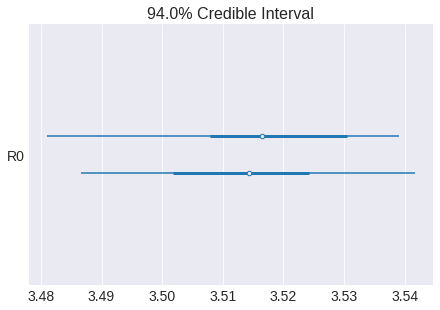

In [22]:
# When beta changes with time you should see R0 change in time also in this graph (y axis is time)
pm.forestplot(trace, var_names=['R0'])

In [24]:
# This shows overall how our distributions fit. We want alot of overlap but not complete...
pm.energyplot(trace)

AttributeError: ignored

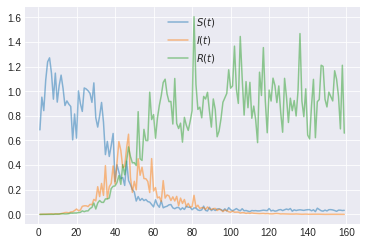

In [25]:

y_n = data.observed_data['Y']
plt.plot(times[1::], y_n[:, 0], color='C0', alpha=0.5, label=f'$S(t)$')
plt.plot(times[1::], y_n[:, 1], color='C1', alpha=0.5, label=f'$I(t)$')
plt.plot(times[1::], y_n[:, 2], color='C2', alpha=0.5, label=f'$R(t)$')
plt.legend()
# plt.title(f'R0={beta/gamma:.2f}; $\\beta$={beta}; $\\gamma$={gamma:.2f}; d={14}')
plt.show()
# Note: this crosses the 100% because we took a lognormal distribution on S,I,R percents...
#       this should probably be changed to ??

In [26]:
!pip install seirsplus

  Created wheel for seirsplus: filename=seirsplus-0.0.14-cp36-none-any.whl size=14320 sha256=791a76456214b260c7c966e2786a3b51c403cafbe5dc02c40af9db39abebc01c
  Stored in directory: /root/.cache/pip/wheels/b9/46/12/112ee3188b6f523d63d60e5a5fd4ed5be80195b4c198d57f91
Successfully built seirsplus


## Quickly play with SEIR/SIR Models

In [0]:
# Info at:
# https://github.com/ryansmcgee/seirsplus#usage-start

from seirsplus.models import *
import networkx

t = 299.90


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


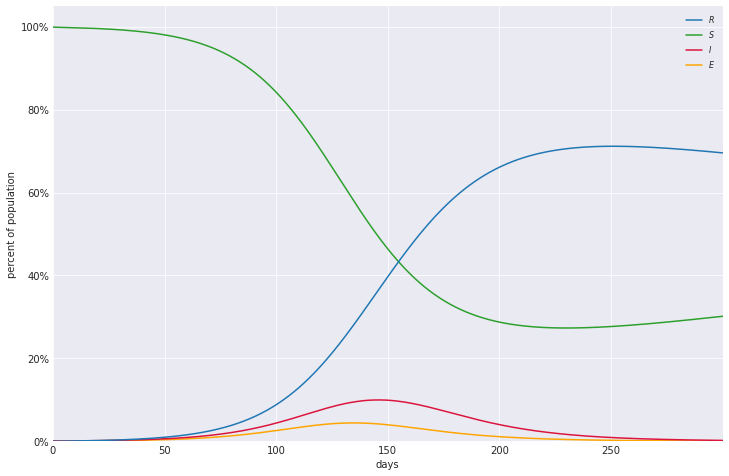

In [29]:
model = SEIRSModel(beta=0.155, sigma=1/5.2, gamma=1/12.39, xi=0.001, initN=100000, initI=100)
model.run(T=300)

# Data
# S = model.numS      # time series of S counts
# E = model.numE      # time series of E counts
# I = model.numI      # time series of I counts
# D_E = model.numD_E    # time series of D_E counts
# D_I = model.numD_I    # time series of D_I counts
# R = model.numR      # time series of R counts
# F = model.numF      # time series of F counts

# t = model.tseries   # time values corresponding to the above time series

# # G_normal     = model.G    # interaction network graph
# # G_quarantine = model.Q    # quarantine interaction network graph

# beta = model.beta   # value of beta parameter (or list of beta values for each node if using network model)
# # similar for other parameters

model.figure_basic()

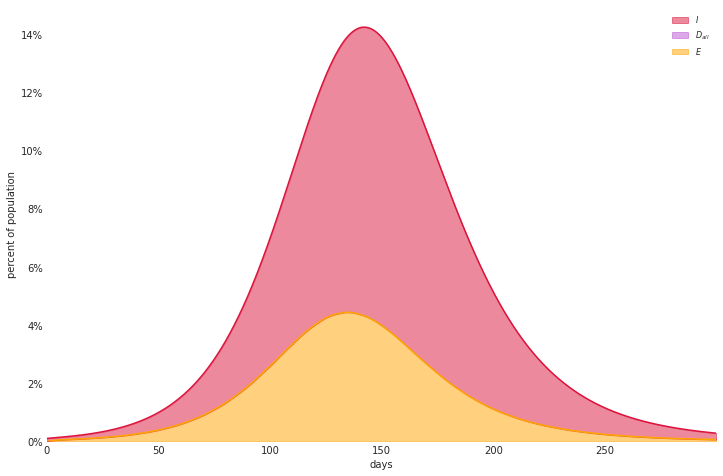

In [30]:
model.figure_infections()